In [19]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/fekmnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data

def heterogeneous_split(data, num_clients=100):
    # Set numpy's random seed.
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    l = len(data["y"])
    client_size = int(np.ceil(l/num_clients))
    
    client_data = []
    
    for i in range(num_clients):        
        client_data.append({"x": sorted_x[i*client_size:(i+1)*client_size], 
                            "y": sorted_y[i*client_size:(i+1)*client_size]})
    
    return client_data


# Performance metric function. Why is the batch size 512 when the split gives 600? => Mini batches?
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.KMNIST(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.KMNIST(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": ((train_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": train_set.targets,
}

test_data = {
    "x": ((test_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": test_set.targets,
}

In [21]:
img, lab = train_set[59999]
img2, lab2 = train_set[59998]
img3, lab3 = train_set[59997]
img4, lab4 = train_set[59994]
fig, axs = plt.subplots(1,4, figsize=(6,1.5))
axs[0].imshow(img.permute(1,2,0))
axs[0].set_title(train_set.classes[lab])
axs[0].set_axis_off()
axs[1].imshow(img2.permute(1,2,0))
axs[1].set_title(train_set.classes[lab2])
axs[1].set_axis_off()
axs[2].imshow(img3.permute(1,2,0))
axs[2].set_title(train_set.classes[lab3])
axs[2].set_axis_off()
axs[3].imshow(img4.permute(1,2,0))
axs[3].set_title(train_set.classes[lab4])
axs[3].set_axis_off()
plt.savefig('Kuzushiji_example_data.pgf', pad_inches=0)
plt.show()

/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_62342/3196438042.py:19: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [5]:
# Get client splits.
client_data = homogeneous_split(train_data, 100, seed=42)


## Define configuration for server and clients

In [6]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(5, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 2000,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 100,
}

## Set up model etc.

In [1]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(100):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

NameError: name 'server_config' is not defined

## Run PVI!

In [8]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 141.962.
Test mll: -0.824. Test acc: 0.740.
Train mll: -0.400. Train acc: 0.884.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 195.550.
Test mll: -0.719. Test acc: 0.767.
Train mll: -0.322. Train acc: 0.906.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 244.030.
Test mll: -0.652. Test acc: 0.793.
Train mll: -0.282. Train acc: 0.917.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 289.938.
Test mll: -0.622. Test acc: 0.806.
Train mll: -0.262. Train acc: 0.923.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 334.484.
Test mll: -0.603. Test acc: 0.813.
Train mll: -0.250. Train acc: 0.928.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 378.461.
Test mll: -0.588. Test acc: 0.819.
Train mll: -0.242. Train acc: 0.931.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 423.933.
Test mll: -0.579. Test acc: 0.821.
Train mll: -0.236. Train acc: 0.932.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 467.084.
Test mll: -0.568. Test acc: 0.825.
Train mll: -0.230. Train acc: 0.934.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 511.309.
Test mll: -0.560. Test acc: 0.828.
Train mll: -0.226. Train acc: 0.936.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 555.050.
Test mll: -0.572. Test acc: 0.824.
Train mll: -0.224. Train acc: 0.936.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 599.084.
Test mll: -0.568. Test acc: 0.828.
Train mll: -0.221. Train acc: 0.938.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 640.739.
Test mll: -0.563. Test acc: 0.829.
Train mll: -0.220. Train acc: 0.938.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 683.853.
Test mll: -0.561. Test acc: 0.827.
Train mll: -0.217. Train acc: 0.939.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 726.294.
Test mll: -0.556. Test acc: 0.831.
Train mll: -0.215. Train acc: 0.938.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 769.344.
Test mll: -0.560. Test acc: 0.829.
Train mll: -0.218. Train acc: 0.939.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 813.470.
Test mll: -0.560. Test acc: 0.832.
Train mll: -0.214. Train acc: 0.939.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 856.551.
Test mll: -0.571. Test acc: 0.827.
Train mll: -0.215. Train acc: 0.940.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 902.019.
Test mll: -0.557. Test acc: 0.830.
Train mll: -0.214. Train acc: 0.940.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 947.358.
Test mll: -0.562. Test acc: 0.827.
Train mll: -0.212. Train acc: 0.941.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 994.212.
Test mll: -0.564. Test acc: 0.829.
Train mll: -0.211. Train acc: 0.941.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 1039.926.
Test mll: -0.560. Test acc: 0.830.
Train mll: -0.212. Train acc: 0.940.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 1084.756.
Test mll: -0.558. Test acc: 0.831.
Train mll: -0.211. Train acc: 0.941.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 1127.513.
Test mll: -0.558. Test acc: 0.831.
Train mll: -0.210. Train acc: 0.941.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 1173.004.
Test mll: -0.562. Test acc: 0.828.
Train mll: -0.211. Train acc: 0.941.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 1219.926.
Test mll: -0.561. Test acc: 0.829.
Train mll: -0.208. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 1265.894.
Test mll: -0.554. Test acc: 0.832.
Train mll: -0.206. Train acc: 0.942.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 1310.064.
Test mll: -0.552. Test acc: 0.831.
Train mll: -0.205. Train acc: 0.942.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 1355.662.
Test mll: -0.555. Test acc: 0.833.
Train mll: -0.205. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 1406.754.
Test mll: -0.555. Test acc: 0.833.
Train mll: -0.204. Train acc: 0.942.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 1451.719.
Test mll: -0.560. Test acc: 0.829.
Train mll: -0.206. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 1500.989.
Test mll: -0.548. Test acc: 0.835.
Train mll: -0.202. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 1548.689.
Test mll: -0.556. Test acc: 0.834.
Train mll: -0.203. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 1599.162.
Test mll: -0.558. Test acc: 0.833.
Train mll: -0.203. Train acc: 0.942.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 33.
Time taken: 1647.766.
Test mll: -0.557. Test acc: 0.831.
Train mll: -0.203. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 34.
Time taken: 1696.024.
Test mll: -0.556. Test acc: 0.833.
Train mll: -0.205. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 35.
Time taken: 1744.160.
Test mll: -0.554. Test acc: 0.833.
Train mll: -0.202. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 36.
Time taken: 1793.119.
Test mll: -0.553. Test acc: 0.831.
Train mll: -0.202. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 37.
Time taken: 1845.234.
Test mll: -0.553. Test acc: 0.832.
Train mll: -0.203. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 38.
Time taken: 1895.589.
Test mll: -0.550. Test acc: 0.832.
Train mll: -0.203. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 39.
Time taken: 1944.707.
Test mll: -0.553. Test acc: 0.831.
Train mll: -0.202. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 40.
Time taken: 1993.412.
Test mll: -0.544. Test acc: 0.834.
Train mll: -0.202. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 41.
Time taken: 2041.652.
Test mll: -0.552. Test acc: 0.834.
Train mll: -0.203. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 42.
Time taken: 2092.232.
Test mll: -0.556. Test acc: 0.834.
Train mll: -0.202. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 43.
Time taken: 2280.719.
Test mll: -0.555. Test acc: 0.834.
Train mll: -0.204. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 44.
Time taken: 2341.448.
Test mll: -0.553. Test acc: 0.834.
Train mll: -0.202. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 45.
Time taken: 2429.248.
Test mll: -0.552. Test acc: 0.834.
Train mll: -0.204. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 46.
Time taken: 2678.772.
Test mll: -0.544. Test acc: 0.837.
Train mll: -0.205. Train acc: 0.943.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 47.
Time taken: 2722.714.
Test mll: -0.548. Test acc: 0.835.
Train mll: -0.201. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 48.
Time taken: 2929.730.
Test mll: -0.549. Test acc: 0.837.
Train mll: -0.199. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 49.
Time taken: 2971.977.
Test mll: -0.549. Test acc: 0.835.
Train mll: -0.200. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [01:54<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 50.
Time taken: 3128.916.
Test mll: -0.551. Test acc: 0.834.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 51.
Time taken: 3171.679.
Test mll: -0.548. Test acc: 0.835.
Train mll: -0.201. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 52.
Time taken: 3210.896.
Test mll: -0.555. Test acc: 0.833.
Train mll: -0.200. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 53.
Time taken: 3254.627.
Test mll: -0.548. Test acc: 0.834.
Train mll: -0.200. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 54.
Time taken: 3366.799.
Test mll: -0.548. Test acc: 0.834.
Train mll: -0.199. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 55.
Time taken: 3409.281.
Test mll: -0.545. Test acc: 0.837.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 56.
Time taken: 3570.790.
Test mll: -0.552. Test acc: 0.833.
Train mll: -0.199. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 57.
Time taken: 3612.980.
Test mll: -0.543. Test acc: 0.837.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 58.
Time taken: 3847.507.
Test mll: -0.545. Test acc: 0.835.
Train mll: -0.198. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 59.
Time taken: 3889.846.
Test mll: -0.547. Test acc: 0.835.
Train mll: -0.201. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 60.
Time taken: 4507.859.
Test mll: -0.548. Test acc: 0.834.
Train mll: -0.199. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 61.
Time taken: 4695.803.
Test mll: -0.550. Test acc: 0.834.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 62.
Time taken: 4738.788.
Test mll: -0.548. Test acc: 0.835.
Train mll: -0.197. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 63.
Time taken: 4780.597.
Test mll: -0.551. Test acc: 0.833.
Train mll: -0.199. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 64.
Time taken: 4823.112.
Test mll: -0.549. Test acc: 0.833.
Train mll: -0.196. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 65.
Time taken: 4864.343.
Test mll: -0.547. Test acc: 0.833.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 66.
Time taken: 5017.918.
Test mll: -0.556. Test acc: 0.829.
Train mll: -0.196. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 67.
Time taken: 5059.812.
Test mll: -0.556. Test acc: 0.833.
Train mll: -0.199. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 68.
Time taken: 5351.583.
Test mll: -0.555. Test acc: 0.834.
Train mll: -0.197. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 69.
Time taken: 5463.736.
Test mll: -0.551. Test acc: 0.836.
Train mll: -0.197. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 70.
Time taken: 5505.334.
Test mll: -0.552. Test acc: 0.834.
Train mll: -0.198. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 71.
Time taken: 5548.000.
Test mll: -0.550. Test acc: 0.833.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 72.
Time taken: 5591.602.
Test mll: -0.552. Test acc: 0.834.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 73.
Time taken: 5635.235.
Test mll: -0.559. Test acc: 0.834.
Train mll: -0.201. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 74.
Time taken: 5680.619.
Test mll: -0.551. Test acc: 0.834.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 75.
Time taken: 5725.801.
Test mll: -0.558. Test acc: 0.831.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 76.
Time taken: 5770.462.
Test mll: -0.558. Test acc: 0.831.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 77.
Time taken: 5817.867.
Test mll: -0.551. Test acc: 0.832.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 78.
Time taken: 5863.585.
Test mll: -0.548. Test acc: 0.835.
Train mll: -0.196. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 79.
Time taken: 5989.703.
Test mll: -0.551. Test acc: 0.835.
Train mll: -0.199. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 80.
Time taken: 6031.198.
Test mll: -0.556. Test acc: 0.832.
Train mll: -0.201. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 81.
Time taken: 6071.910.
Test mll: -0.557. Test acc: 0.831.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 82.
Time taken: 6116.345.
Test mll: -0.545. Test acc: 0.836.
Train mll: -0.196. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 83.
Time taken: 6160.270.
Test mll: -0.547. Test acc: 0.835.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 84.
Time taken: 6200.729.
Test mll: -0.547. Test acc: 0.834.
Train mll: -0.198. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 85.
Time taken: 6244.066.
Test mll: -0.549. Test acc: 0.836.
Train mll: -0.196. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 86.
Time taken: 6285.064.
Test mll: -0.549. Test acc: 0.833.
Train mll: -0.198. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 87.
Time taken: 6331.333.
Test mll: -0.548. Test acc: 0.833.
Train mll: -0.198. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 88.
Time taken: 6374.823.
Test mll: -0.552. Test acc: 0.831.
Train mll: -0.199. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 89.
Time taken: 6416.705.
Test mll: -0.554. Test acc: 0.833.
Train mll: -0.200. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 90.
Time taken: 6459.069.
Test mll: -0.553. Test acc: 0.835.
Train mll: -0.199. Train acc: 0.945.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 91.
Time taken: 6499.587.
Test mll: -0.558. Test acc: 0.831.
Train mll: -0.198. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 92.
Time taken: 6541.555.
Test mll: -0.549. Test acc: 0.835.
Train mll: -0.196. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 93.
Time taken: 6585.329.
Test mll: -0.557. Test acc: 0.833.
Train mll: -0.199. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 94.
Time taken: 6640.383.
Test mll: -0.550. Test acc: 0.834.
Train mll: -0.194. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 95.
Time taken: 6680.916.
Test mll: -0.551. Test acc: 0.834.
Train mll: -0.194. Train acc: 0.947.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 96.
Time taken: 6726.627.
Test mll: -0.549. Test acc: 0.834.
Train mll: -0.195. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 97.
Time taken: 6772.631.
Test mll: -0.552. Test acc: 0.836.
Train mll: -0.195. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 98.
Time taken: 6823.243.
Test mll: -0.549. Test acc: 0.833.
Train mll: -0.192. Train acc: 0.946.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterations: 99.
Time taken: 6879.541.
Test mll: -0.548. Test acc: 0.835.
Train mll: -0.195. Train acc: 0.946.



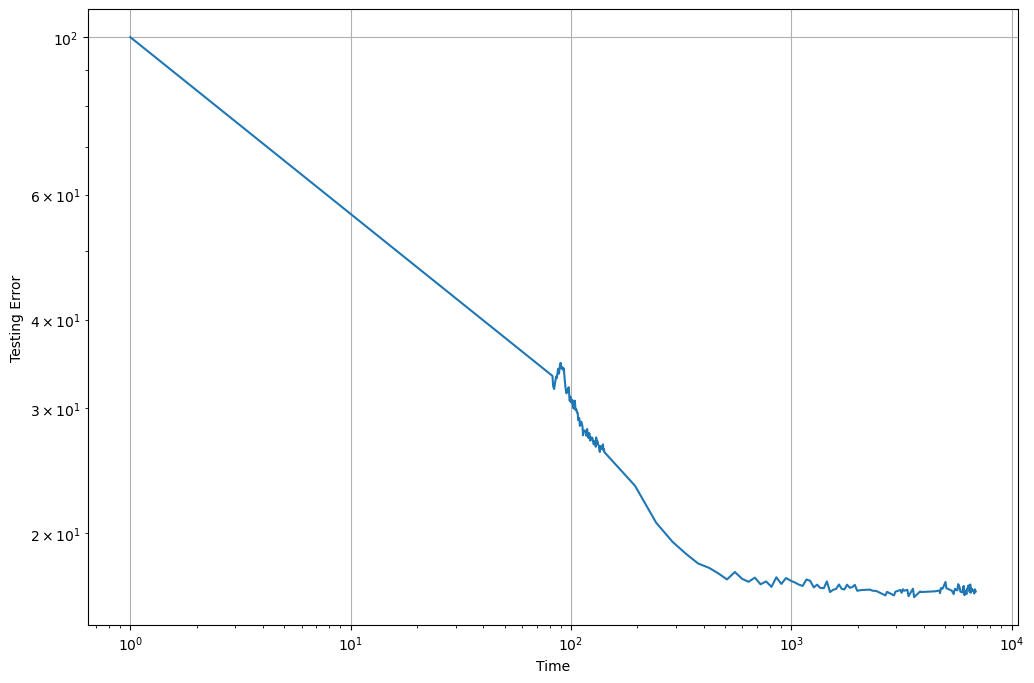

In [41]:
train_acc = []
val_acc = []
times = []
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
plt.figure(figsize=(12,8))
plt.xscale("log")
plt.yscale("log")
plt.plot(times, val_acc)
plt.grid(visible=True)
plt.xlabel("Time")
plt.ylabel("Testing Error")
plt.savefig("PVI on KMNIST, lr=0.002.png")
plt.show()

In [44]:
100-min(val_acc)

tensor(83.7500)

In [42]:
print(val_acc)

[100.0, tensor(33.3100), tensor(32.2500), tensor(31.9200), tensor(33.2400), tensor(33.0600), tensor(33.5200), tensor(34.0900), tensor(34.0200), tensor(33.5600), tensor(34.6300), tensor(34.7500), tensor(34.1300), tensor(34.2800), tensor(33.9600), tensor(34.1600), tensor(34.1100), tensor(32.9400), tensor(31.9100), tensor(31.7000), tensor(31.4800), tensor(31.8100), tensor(31.8100), tensor(31.9500), tensor(32.1100), tensor(30.7400), tensor(30.8000), tensor(31.1400), tensor(30.6200), tensor(30.8500), tensor(30.4600), tensor(30.7900), tensor(29.9900), tensor(30.1700), tensor(29.9500), tensor(30.7400), tensor(30.1400), tensor(29.8400), tensor(29.8800), tensor(29.5900), tensor(29.6100), tensor(29.5200), tensor(28.8600), tensor(29.0400), tensor(29.0700), tensor(28.9700), tensor(28.3200), tensor(28.3800), tensor(28.4300), tensor(28.6900), tensor(28.7100), tensor(28.2900), tensor(27.4700), tensor(27.7000), tensor(27.7800), tensor(27.9100), tensor(27.8700), tensor(27.4400), tensor(28.0400), tensor